# ARCH Model Implementation

The ARCH model can be used to predict volatility. The sliding window method is used to fit the ARCH model on historical data. In the sliding window method, the ARCH model constants and coefficients are calculated every day by fitting the ARCH model on the latest data of a fixed number of periods. 

In this notebook, we will perform the following steps:

1. [Read the data](#read)
1. [Calculate log returns](#log)
1. [Calculate the annualised historical volatility](#vol)
1. [Volatility forecasting using ARCH](#arch)
1. [Analysing ARCH volatility forecasts](#arch_normal)
7. [Volatility forecasting using GARCH](#garch)
8. [Analysing GARCH volatility forecasts](#analyse)
9. [Comparing the ARCH and GARCH forecasts](#graphs)

## Import the necessary libraries

In [1]:
import yfinance as yf
import datetime

# Data manipulation
import numpy as np
import pandas as pd

# For implementing the ARCH model
from arch import arch_model

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')



/var/folders/cp/bkd_fjpn4h3g5xz9g867z6cw0000gn/T/ipykernel_46446/3184439438.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Define the ticker symbol for S&P 500 ETF (SPY)
ticker = 'SPY'

# Define the date range
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2020, 6, 30)

# Fetch the data
SP500_data = yf.download(ticker, start=start_date, end=end_date)

SP500_data_arch = SP500_data.copy()

# Replace "Close" with "Adjusted Close"
SP500_data['Close'] = SP500_data['Adj Close']

# Drop the "Adj Close" column
SP500_data.drop(columns=['Adj Close'], inplace=True)

# Print the first few rows of the data
SP500_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,245.979996,251.210007,245.949997,232.308792,126925200
2019-01-03,248.229996,248.570007,243.669998,226.765228,144140700
2019-01-04,247.589996,253.110001,247.169998,234.360916,142628800
2019-01-07,252.690002,255.949997,251.690002,236.208817,103139100
2019-01-08,256.820007,257.309998,254.000000,238.428009,102512600


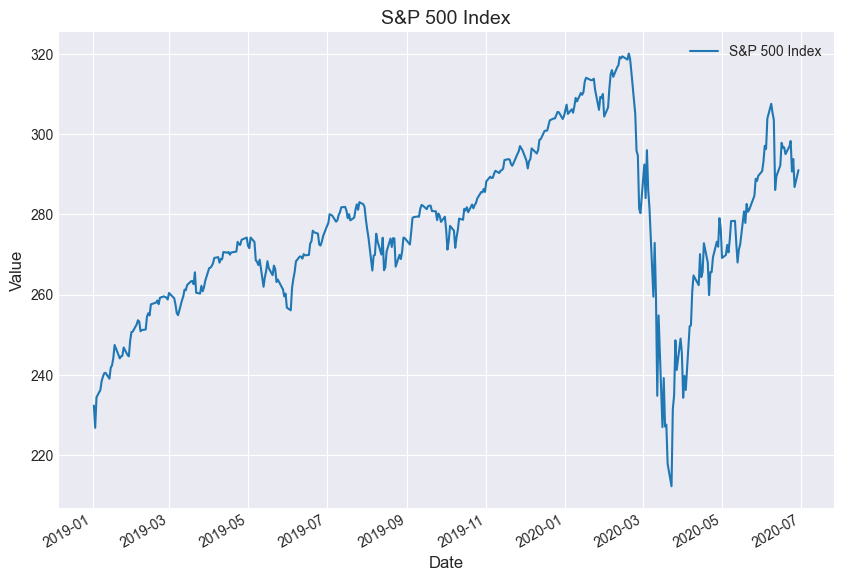

In [3]:
SP500_data['Close'].plot(figsize=(10, 7))
# Set title and labels for the plot
plt.title('S&P 500 Index', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.plot()
plt.legend(['S&P 500 Index'])
plt.show()

<a id='log'></a> 
## Calculate log returns

In [4]:
SP500_data['log_returns'] = np.log(SP500_data['Close'].pct_change() + 1)*100
SP500_data = SP500_data.dropna()

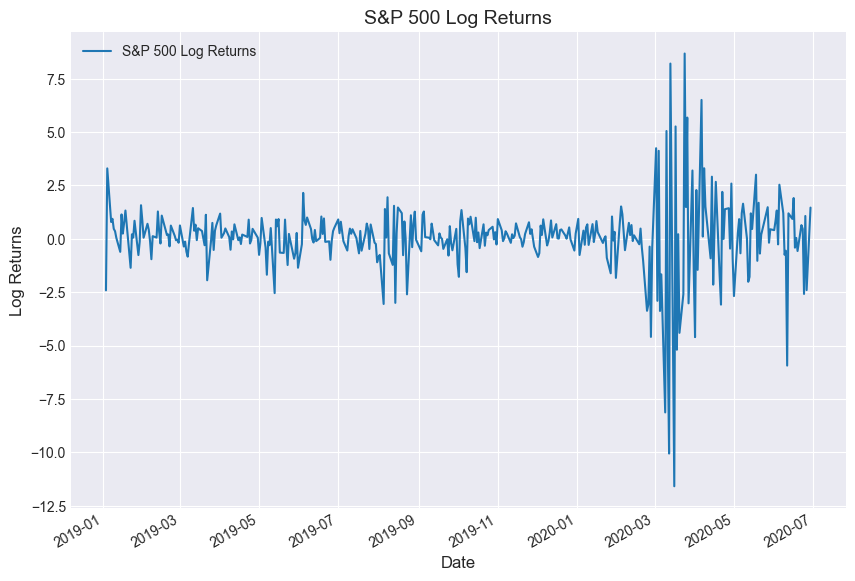

In [5]:
SP500_data['log_returns'].plot(figsize=(10, 7))
# Set title and labels for the plot
plt.title('S&P 500 Log Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Returns', fontsize=12)
plt.legend(['S&P 500 Log Returns'])
plt.show()

<a id='vol'></a> 
## Calculate the annualised historical volatility
The annualised historical volatility is calculated by taking the daily volatility of the last 14 days and then annualised. The choice of 14 days is just for illustration purposes. This can be changed when you tweak the code.

In [6]:
# Annualised volatilty
SP500_data['actual_historical_volatility'] = SP500_data['log_returns'].rolling(14).std() * ((252)**0.5)

# Print the last 5 rows
SP500_data_arch.round(2).tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-23,313.49,314.50,311.61,312.05,298.29,68471200
2020-06-24,309.84,310.51,302.10,304.09,290.68,132813500
2020-06-25,303.47,307.64,301.28,307.35,293.80,89468000
2020-06-26,306.16,306.39,299.42,300.05,286.82,127961000
2020-06-29,301.41,304.61,298.93,304.46,291.03,79773300


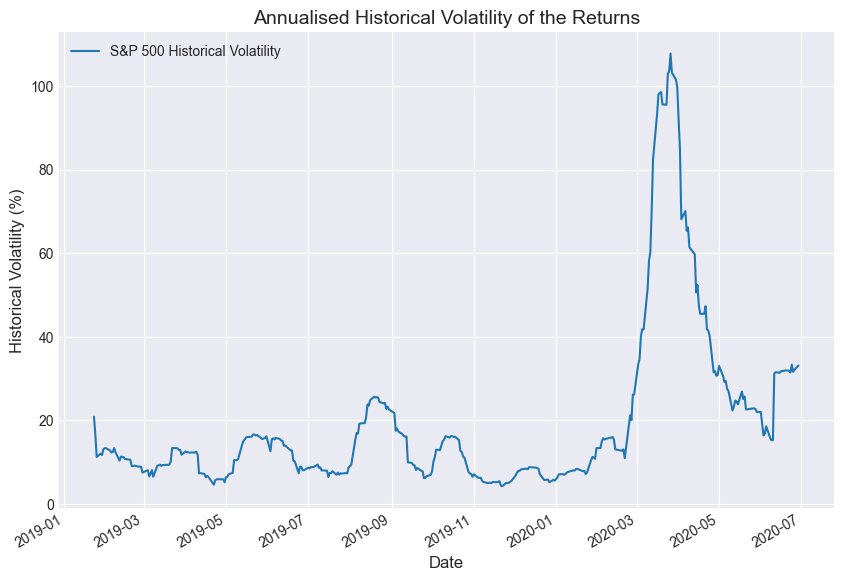

In [7]:
SP500_data['actual_historical_volatility'].plot(figsize=(10, 7))
# Set title and labels for the plot
plt.title('Annualised Historical Volatility of the Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Historical Volatility (%)', fontsize=12)
plt.legend(['S&P 500 Historical Volatility'])
plt.show()

<a id='arch'></a> 
## Volatility forecasting using ARCH
The equation of the ARCH model is:

$$
\sigma_{t+1} ^ 2 = \alpha_0 + \alpha_1 * r_t ^2
$$
where 
* $\sigma_{t+1} ^ 2$ is the ARCH predicted variance,
* $r_{t} ^ 2$ is the current period returns,
* $\alpha_0$ is a constant and
* $\alpha_1$ is the autoregressive coefficient.

The ARCH model in Python is implemented using the `arch_model` function. The syntax is shown below.

Syntax: 
```python
arch_model(historical_data, vol='ARCH', p=order_of_ARCH_model, dist=distribution_of_the_data)
```
1. historical_data: Historical data whose volatility is to be predicted
1. vol='ARCH': Type of model to use
1. order_of_ARCH_model: The order of the ARCH(p) model
1. distribution_of_the_data: distribution of the input data. Empirically, for most financial data, this is Skewed Student’s-t distribution or 'skewt'

In [8]:
# Function to predict the volatility of 1 day
def predict_volatility(hist_returns_data):
    # Define model
    gm = arch_model(hist_returns_data, vol='ARCH', p=1, dist='skewt')

    # Fit the model
    gm_fit = gm.fit(disp='off') 
    
    # Make forecast
    forecasted_variance = gm_fit.forecast(horizon=1).variance.values[-1]

    # Forecasted volatility
    forecasted_volatility = forecasted_variance**0.5

    # Calculate and return the annualised forecasted variance
    annualised_volatility = forecasted_volatility * (252**0.5)
    return annualised_volatility

# Calculate the ARCH predicted volatility for the each day    
SP500_data['ARCH_predicted_volatility'] = SP500_data['log_returns'].rolling(252).apply(predict_volatility, raw=True)

# Shift the ARCH predicted volatility to match with the actual historical volatility on each day    
SP500_data['ARCH_predicted_volatility'] = SP500_data['ARCH_predicted_volatility'].shift(1)

<a id='arch_normal'></a> 
## Analysing ARCH volatility forecasts
### Normal market scenario

In [9]:
# Showing an example of the normal market scenario
SP500_data[['log_returns','ARCH_predicted_volatility', 'actual_historical_volatility']].dropna()[30:35].round(2)

,log_returns,ARCH_predicted_volatility,actual_historical_volatility
Date,,,
2020-02-18,-0.26,10.87,12.83
2020-02-19,0.48,11.12,12.80
2020-02-20,-0.41,11.17,13.10
2020-02-21,-1.04,11.43,10.96
2020-02-24,-3.37,13.56,18.64


### Adverse market scenario

In [10]:
# Showing an example of the adverse market scenario
SP500_data[['log_returns','ARCH_predicted_volatility', 'actual_historical_volatility']].dropna()[40:45].round(2)

,log_returns,ARCH_predicted_volatility,actual_historical_volatility
Date,,,
2020-03-03,-2.91,37.82,34.66
2020-03-04,4.12,29.97,40.14
2020-03-05,-3.38,44.51,41.83
2020-03-06,-1.67,40.61,41.75
2020-03-09,-8.13,23.48,51.59


# GARCH Model Implementation

The GARCH model is the generalised ARCH model and is implemented in the same fashion as the ARCH model. The GARCH model is then used to predict volatility. 

The equation of the GARCH model is:

$$
\sigma_{t+1} ^ 2 = \alpha_0 + \alpha_1 * r_t ^2 + \beta_1 * \sigma_{t} ^ 2
$$
where 
* $\sigma_{t+1} ^ 2$ is the ARCH predicted variance,
* $r_{t} ^ 2$ is the current period returns,
* $\alpha_0$ is a constant,
* $\alpha_1$ is the autoregressive coefficient and
* $\beta_1$ is the conditional regression coefficient.



<a id='garch'></a> 
## Volatility forecasting using GARCH

The GARCH model in Python is implemented using the `arch_model` function. The syntax is shown below.

Syntax: 
```python
arch_model(historical_data, vol='GARCH', p=AR_order, q=MA_order, dist=distribution_of_the_data)
```
1. `historical_data`: Historical data whose volatility is to be predicted
1. `vol='GARCH'`: Type of model to use
1. `AR_order`: The AR order (p) of the GARCH(p,q) model
1. `MA_order`: The MA order (q) of the GARCH(p,q) model
1. `distribution_of_the_data`: distribution of the input data. Empirically, for most financial data, this is Skewed Student’s-t distribution or 'skewt'

In [11]:
# Function to predict the volatility of 1 day
def predict_volatility(hist_returns_data):
    # Define model
    gm = arch_model(hist_returns_data, vol='GARCH', p=1, q=1, dist='skewt')

    # Fit the model
    gm_fit = gm.fit(disp='off') 
    
    # Make forecast
    forecasted_variance = gm_fit.forecast(horizon=1).variance.values[-1]

    # Forecasted volatility
    forecasted_volatility = forecasted_variance**0.5

    # Calculate and return the annualised forecasted variance
    annualised_volatility = forecasted_volatility * (252**0.5)
    return annualised_volatility

# Calculate the GARCH predicted volatility for the each day    
SP500_data['GARCH_predicted_volatility'] = SP500_data['log_returns'].rolling(252).apply(predict_volatility, raw=True)

# Shift the GARCH predicted volatility to match with the actual historical volatility on each day    
SP500_data['GARCH_predicted_volatility'] = SP500_data['GARCH_predicted_volatility'].shift(1)

<a id='analyse'></a> 
## Analysing GARCH volatility forecasts


In [12]:
# Showing an example where the ARCH failed to capture volatility clustering but GARCH captures it well
SP500_data[['log_returns','ARCH_predicted_volatility','GARCH_predicted_volatility', 'actual_historical_volatility']].dropna()[65:70].round(2)

,log_returns,ARCH_predicted_volatility,GARCH_predicted_volatility,actual_historical_volatility
Date,,,,
2020-04-07,0.10,102.38,69.39,65.34
2020-04-08,3.30,13.36,58.86,66.16
2020-04-09,1.51,52.41,56.85,61.42
2020-04-13,-0.92,26.23,49.57,59.71
2020-04-14,2.91,21.55,42.74,50.63


<a id='graphs'></a> 
## Comparing the ARCH and GARCH forecasts

In [13]:
SP500_data.dropna(inplace=True)

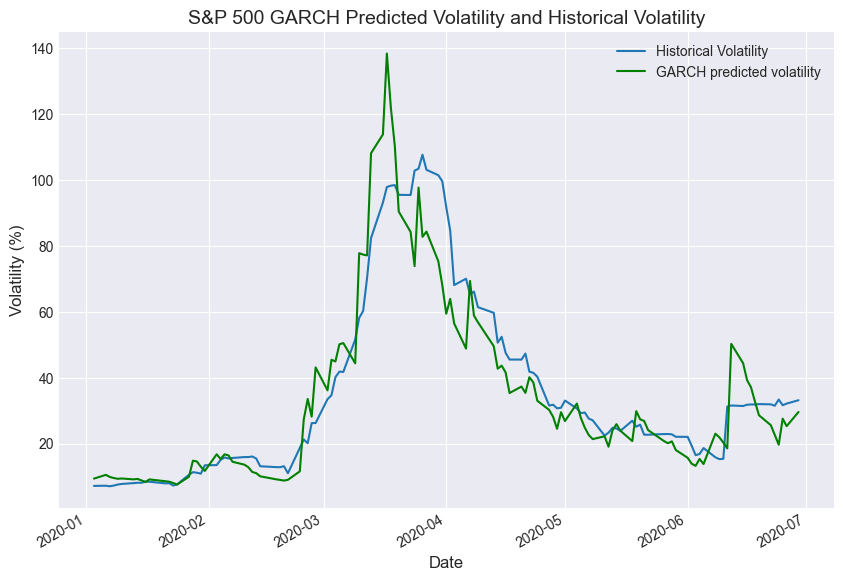

In [14]:
SP500_data['actual_historical_volatility'].plot(figsize=(10, 7))
SP500_data['GARCH_predicted_volatility'].plot(figsize=(10, 7), color='green')
# Set title and labels for the plot
plt.title('S&P 500 GARCH Predicted Volatility and Historical Volatility', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend(['Historical Volatility', 'GARCH predicted volatility'])
plt.show()

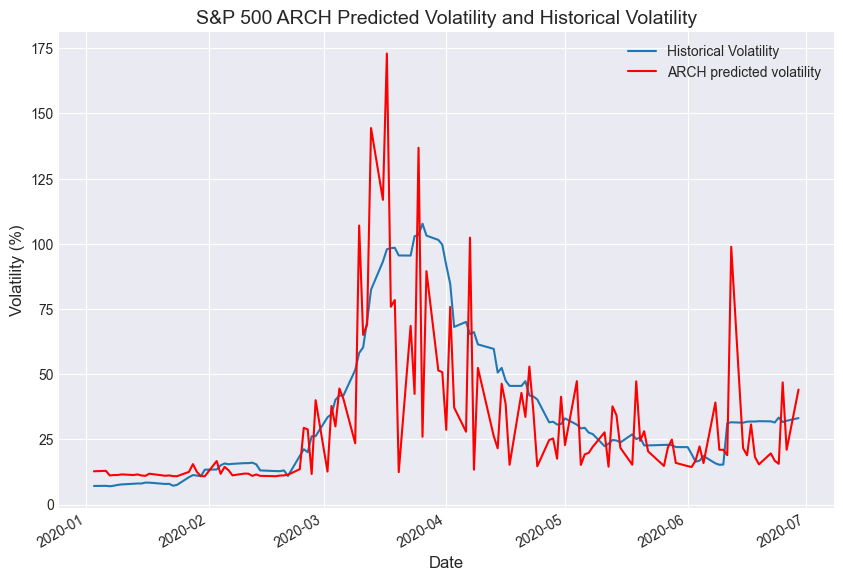

In [15]:
SP500_data['actual_historical_volatility'].plot(figsize=(10, 7))
SP500_data['ARCH_predicted_volatility'].plot(figsize=(10, 7), color='red')
# Set title and labels for the plot
plt.title('S&P 500 ARCH Predicted Volatility and Historical Volatility', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend(['Historical Volatility', 'ARCH predicted volatility'])
plt.show()